# Generate a prettier plot with statistics on the plot

In [1]:
library(repr)
library(ggpubr)
library(tidyverse)

Loading required package: ggplot2

-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
config <- list('caudate'= '../../../caudate/_m/genes/diffExpr_maleVfemale_full.txt',
               'dlpfc'= '../../../dlpfc/_m/genes/diffExpr_maleVfemale_full.txt', 
               'hippo'= '../../../hippocampus/_m/genes/diffExpr_maleVfemale_full.txt', 
               'cmc_dlpfc'= '../../../cmc_dlpfc/_m/genes/diffExpr_maleVfemale_full.txt')

In [3]:
get_deg <- function(fn){
    dft <- data.table::fread(fn)
    if('gene_id' %in% colnames(dft)){
        dft <- dft %>% 
            mutate(Feature=gene_id, Dir=sign(dft$t)) %>% 
            rename(ensemblID=ensembl_gene_id) %>%
            select('Feature', 'ensemblID', 'adj.P.Val', 'logFC', 't', 'Dir')
    } else {
        dft <- dft %>% 
            mutate(Feature=V1, Dir=sign(dft$t)) %>% 
            select('Feature', 'ensemblID', 'adj.P.Val', 'logFC', 't', 'Dir')
    }
    return(dft)
}

get_deg_sig <- function(fn, fdr){
    dft <- get_deg(fn)
    return(subset(dft, adj.P.Val < fdr))
}

merge_dataframe <- function(tissue1, tissue2){
    return(merge(get_deg(config[[tissue1]]), get_deg(config[[tissue2]]), 
                 by='Feature', suffixes=c(paste0('_',tissue1), paste0('_',tissue2))))
}

merge_dataframes_sig <- function(tissue1, tissue2){
    fdr = 0.05
    return(merge(get_deg_sig(config[[tissue1]], fdr), get_deg_sig(config[[tissue2]], fdr), 
                 by='Feature', suffixes=c(paste0('_',tissue1), paste0('_',tissue2))))
}

tissue_annotation <- function(tissue){
    return(list('dlpfc'='DLPFC', 'hippo'='Hippocampus', 
                'caudate'='Caudate', 'cmc_dlpfc'='CMC DLPFC')[[tissue]])
}

get_scatter_plot <- function(tissue1, tissue2, merge_fnc, coords){
    dft <- merge_fnc(tissue1, tissue2)
    sp = ggscatter(dft, x=paste0('t_', tissue1), y=paste0('t_', tissue2), add="reg.line", 
                   xlab=paste0('T-statistic (',tissue_annotation(tissue1), ')'),
                   ylab=paste0('T-statistic (',tissue_annotation(tissue2), ')'),
                   add.params = list(color = "blue", fill = "lightgray"), conf.int = FALSE, 
                   cor.method = "pearson", cor.coef = FALSE, cor.coef.size = 7, 
                   cor.coeff.args = list(label.sep = "\n"),  #cor.coef.coord = coords, 
                   ylim=c(-125, 125)) + 
    stat_cor(aes(label = paste0(..rr.label..)), size=8, method = "pearson") + 
    font("xylab", size = 20, face='bold') + font("xy.text", size = 18)
    return(sp)
}


save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



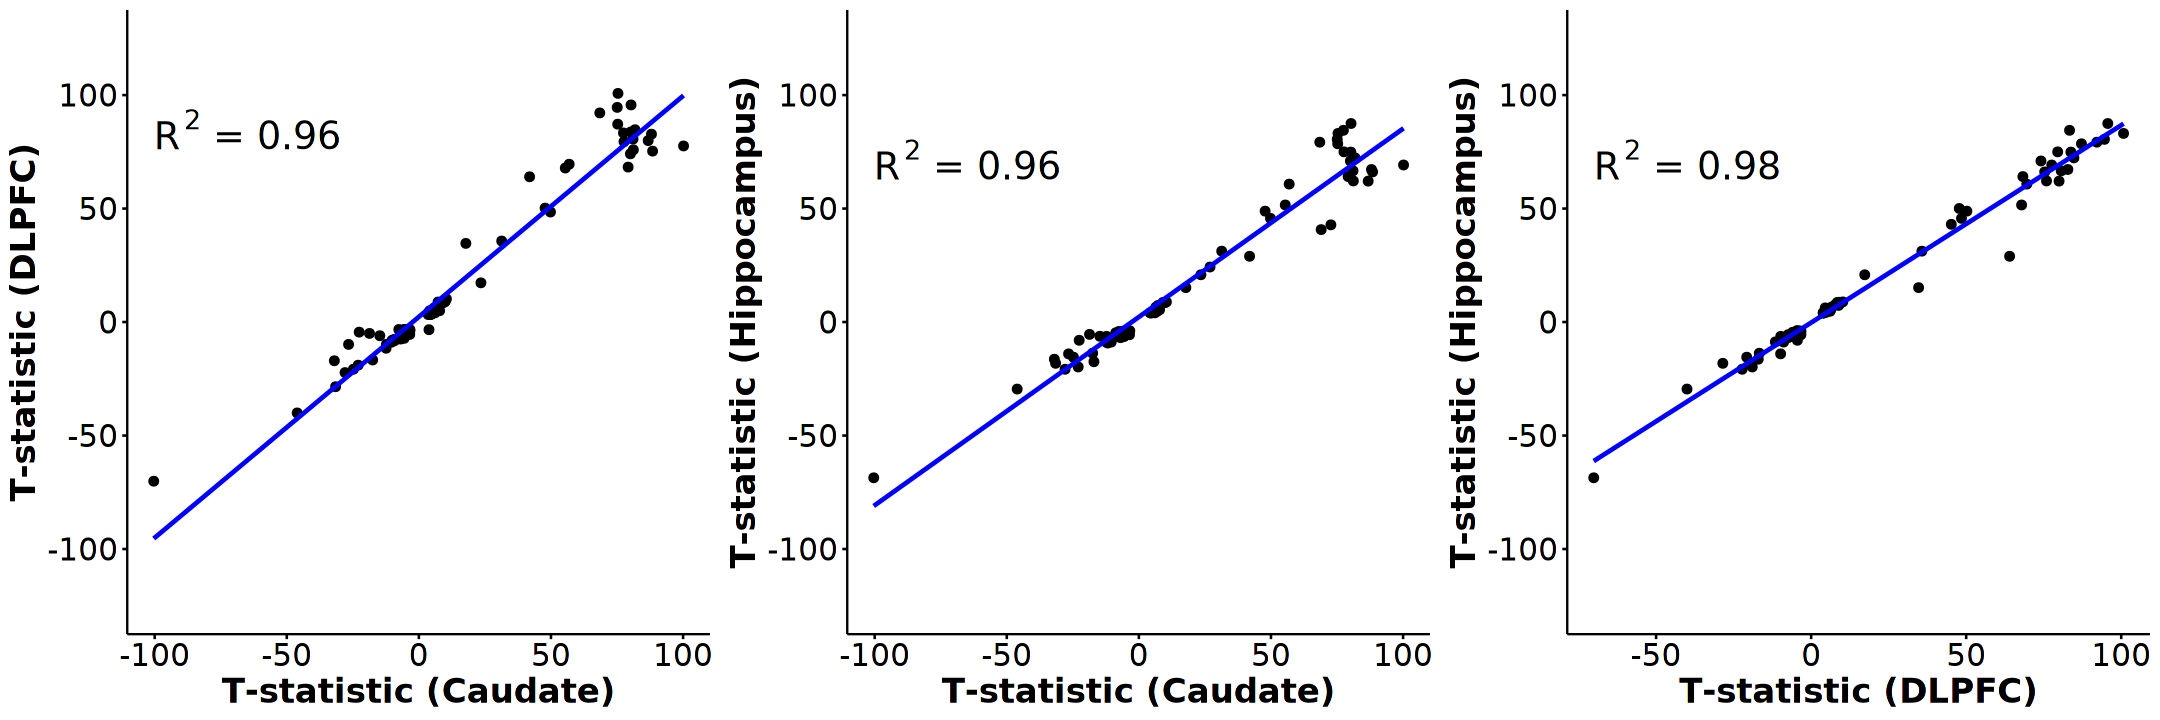

In [4]:
options(repr.plot.width=18, repr.plot.height=6)
sp1_sig = get_scatter_plot('caudate', 'dlpfc', merge_dataframes_sig, c(-110, 85))
sp2_sig = get_scatter_plot('caudate', 'hippo', merge_dataframes_sig, c(-110, 85))
sp3_sig = get_scatter_plot('dlpfc', 'hippo', merge_dataframes_sig, c(-110, 85))
fig1 = ggarrange(sp1_sig, sp2_sig, sp3_sig, ncol=3, align='v')
print(fig1)

In [6]:
save_ggplots("tstatistic_corr_sig", fig1, 18, 6)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



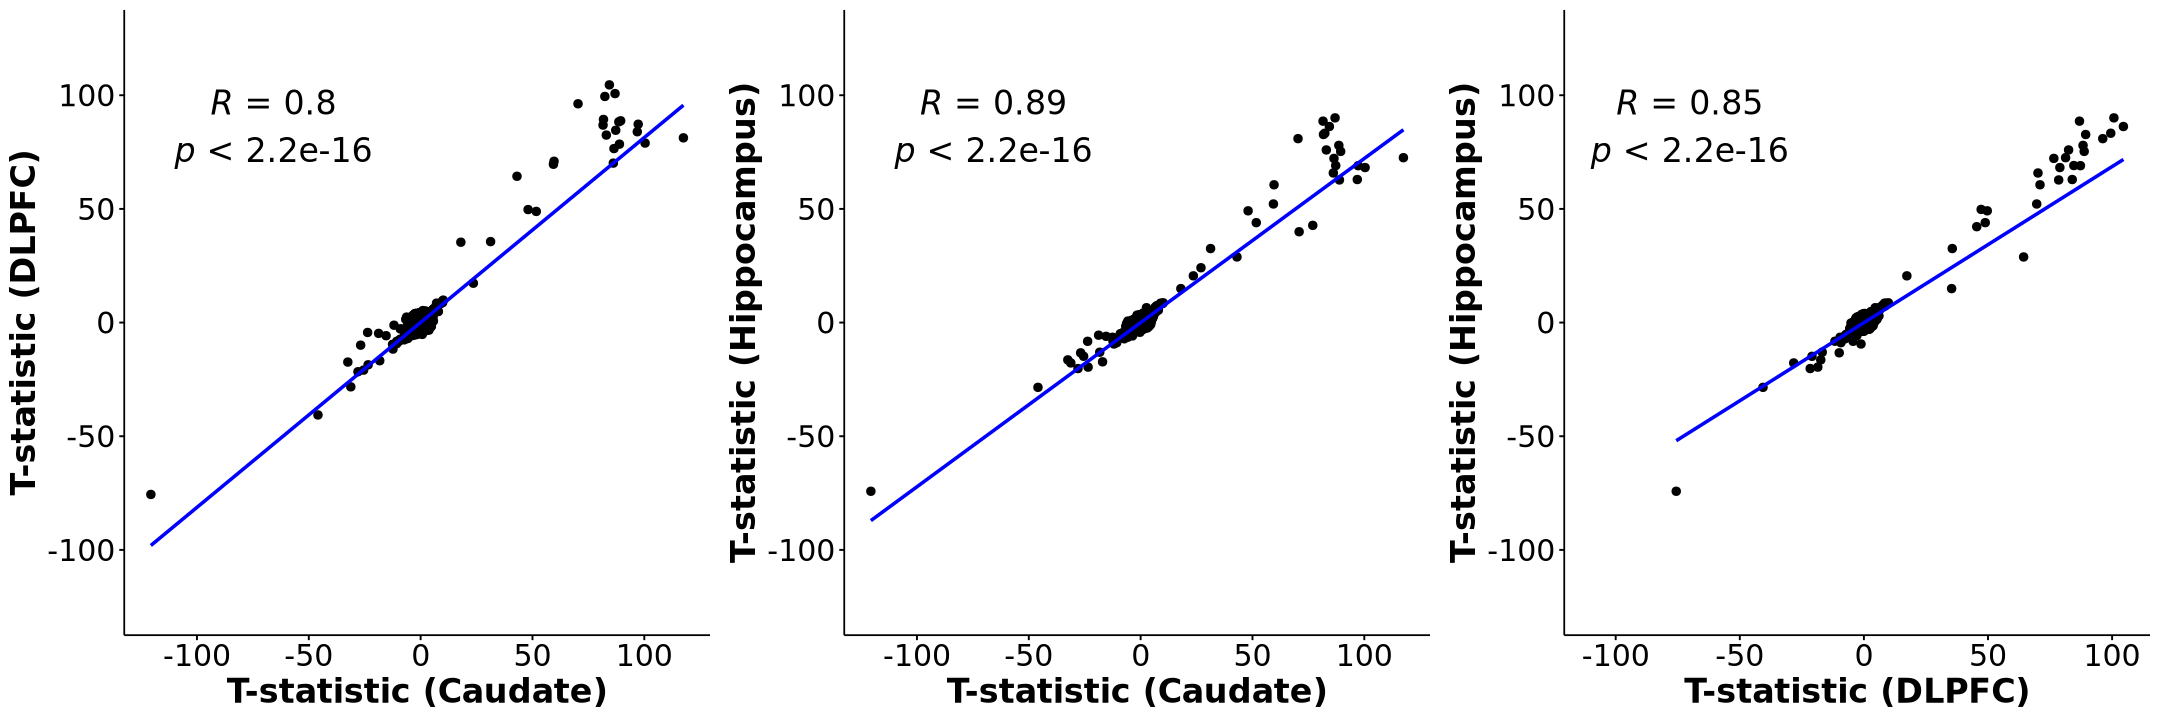

In [7]:
sp1 = get_scatter_plot('caudate', 'dlpfc', merge_dataframe, c(-110, 85))
sp2 = get_scatter_plot('caudate', 'hippo', merge_dataframe, c(-110, 85))
sp3 = get_scatter_plot('dlpfc', 'hippo', merge_dataframe, c(-110, 85))
fig2 = ggarrange(sp1, sp2, sp3, ncol=3, align='v')
print(fig2)

In [12]:
save_ggplots("tstatistic_corr", fig2, 18, 6)

file saved to tstatistic_corr.pdf

file saved to tstatistic_corr.png



## CommonMind comparison

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



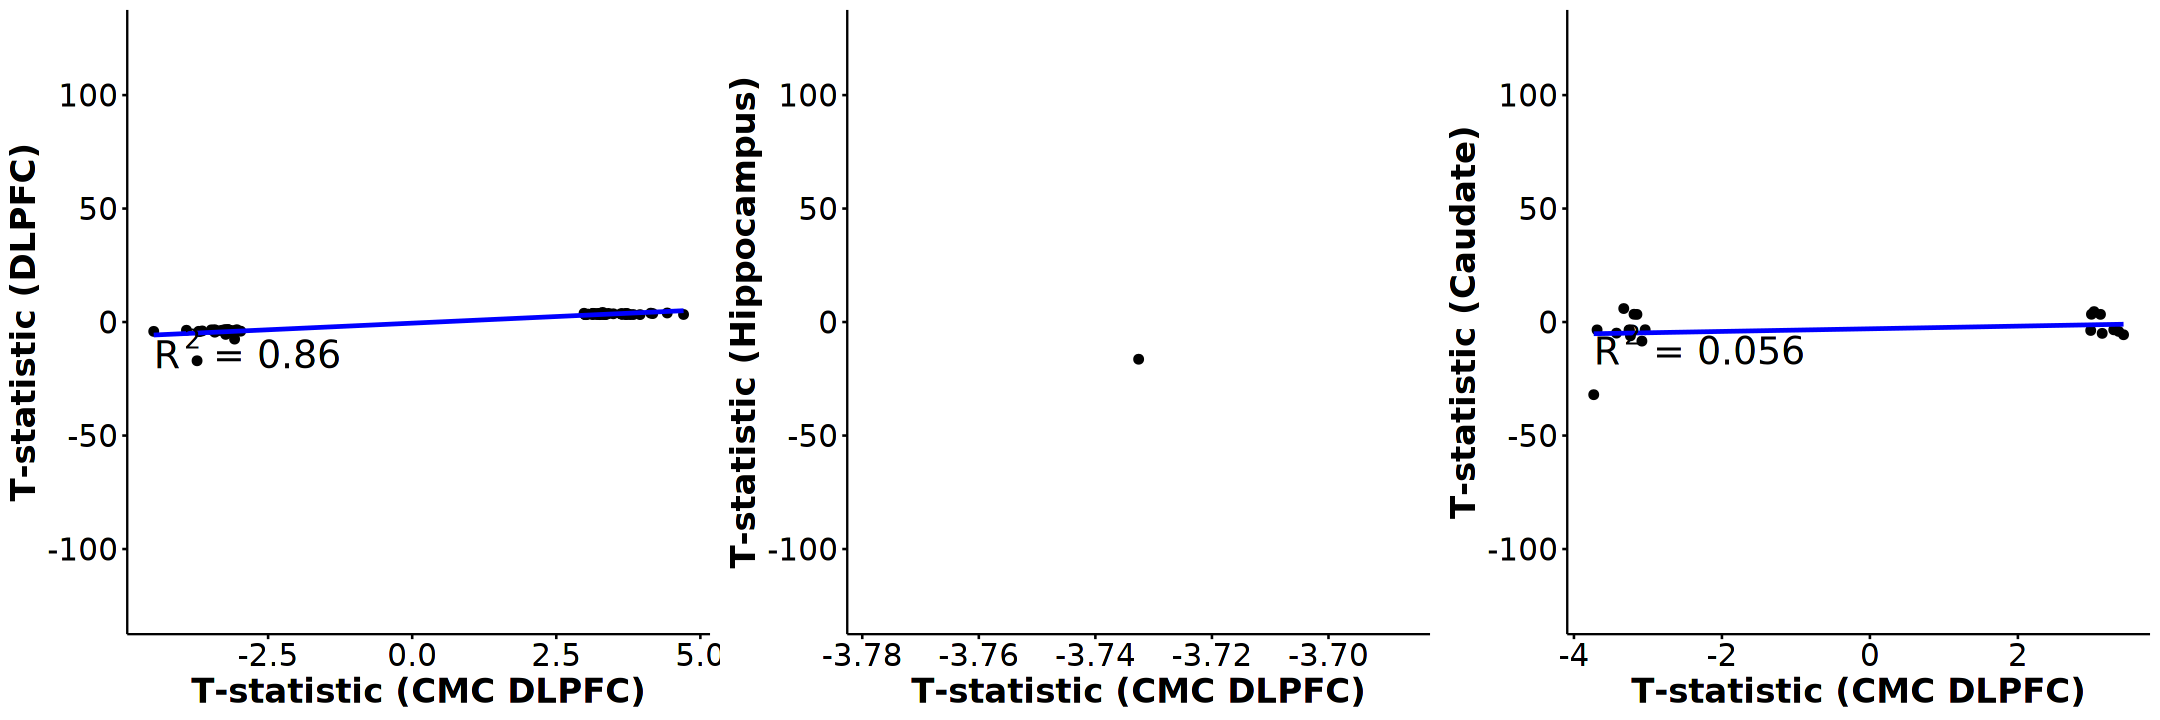

In [5]:
sp4_sig = get_scatter_plot('cmc_dlpfc', 'dlpfc', merge_dataframes_sig, c(-55, 85))
sp5_sig = get_scatter_plot('cmc_dlpfc', 'hippo', merge_dataframes_sig, c(-55, 85))
sp6_sig = get_scatter_plot('cmc_dlpfc', 'caudate', merge_dataframes_sig, c(-55, 85))
fig3 = ggarrange(sp4_sig, sp5_sig, sp6_sig, ncol=3, align='v')
print(fig3)

In [26]:
save_ggplots("cmc_tstatistic_corr_sig", fig3, 18, 6)

Warning message in data.table::fread(fn):
"Detected 16 column names but the data has 17 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in data.table::fread(fn):
"Detected 16 column names but the data has 17 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
Warning message in data.table::fread(fn):
"Detected 16 column names but the data has 17 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write co

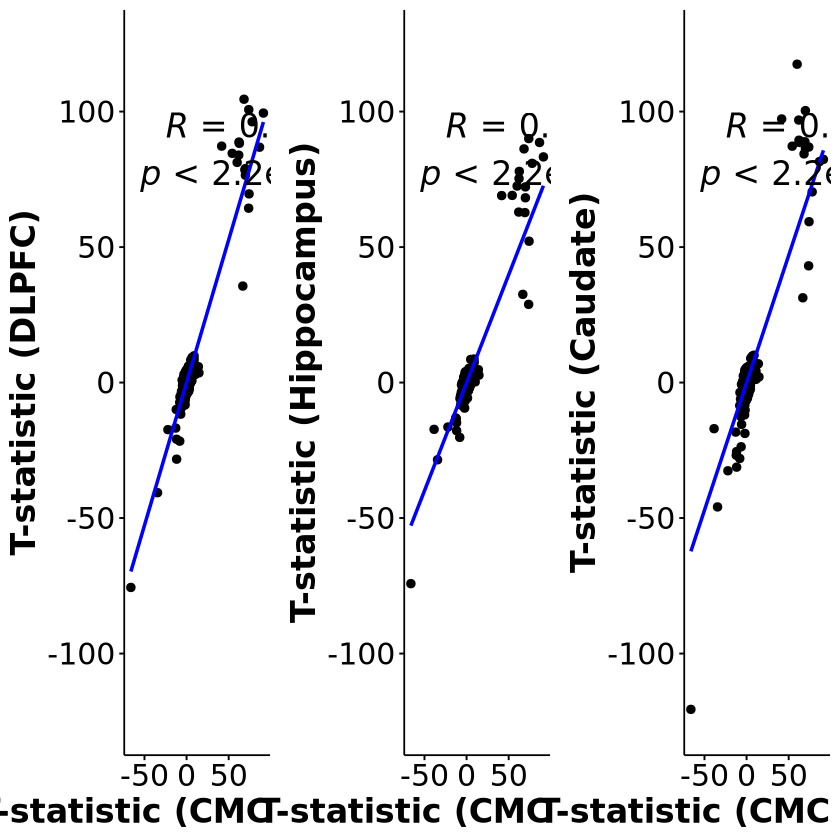

In [27]:
sp4 = get_scatter_plot('cmc_dlpfc', 'dlpfc', merge_dataframe, c(-55, 85))
sp5 = get_scatter_plot('cmc_dlpfc', 'hippo', merge_dataframe, c(-55, 85))
sp6 = get_scatter_plot('cmc_dlpfc', 'caudate', merge_dataframe, c(-55, 85))
fig4 = ggarrange(sp4, sp5, sp6, ncol=3)
print(fig4)

In [28]:
save_ggplots("cmc_tstatistic_corr", fig4, 18, 6)

## Reproducibility Information

In [ ]:
print("Reproducibility Information:")
Sys.time()
proc.time()
options(width=120)
sessioninfo::session_info()